In [1]:
# Import required libraries
import flopy
import numpy as np
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

flopy is installed in c:\python37-32\lib\site-packages\flopy


In [2]:
# Assign name and create modflow model object
modelname = 'tutorial1'
modelpath = '../Model/'
mf = flopy.modflow.Modflow(modelname, model_ws=modelpath,exe_name='../Exe/mf2005')

In [3]:
# Model domain and grid definition
Lx = 1000.
Ly = 1000.
ztop = 50.
zbot = 0.
nlay = 1
nrow = 10
ncol = 10
delr = Lx / ncol
delc = Ly / nrow
# delv = (ztop - zbot) / nlay
# botm = np.linspace(ztop, zbot, nlay + 1)
steady=True

In [4]:
# Create the discretization object
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc,
                               top=ztop, botm=zbot,steady=steady)

In [5]:
# Check top and bottom arrays
print(dis.top.array)
print(dis.top.array.shape)
print(dis.botm.array)
print(dis.botm.array.shape)

[[50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]
 [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.]]
(10, 10)
[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
(1, 10, 10)


In [6]:
# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 30.
strt[:, :, -1] =20.
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, hnoflo=-999.99,strt=strt)

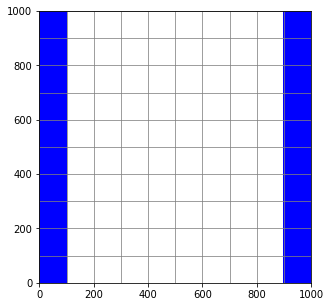

In [7]:
# Plot the model grid and boundary
fig = plt.figure(figsize=(5, 5))
ax=fig.add_subplot(1,1,1,aspect='equal')
modelmap = flopy.plot.PlotMapView(model=mf)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid(linewidth=0.5)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid(linewidth=0.5)

In [8]:
# Add LPF package to the MODFLOW model, laytyp=1, unconfined aquifer
lpf = flopy.modflow.ModflowLpf(mf, laytyp=1,hk=10., vka=10., ipakcb=53)

In [9]:
# Add OC package to the MODFLOW model
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)
# oc = flopy.modflow.ModflowOc(mf)

In [10]:
# Add PCG package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(mf)

In [11]:
# Write the MODFLOW model input files
mf.write_input()

In [12]:
# Run the MODFLOW model
success, buff = mf.run_model()

FloPy is using the following  executable to run the model: ../Exe/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: tutorial1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/07/18 15:18:25

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/07/18 15:18:25
 Elapsed run time:  0.018 Seconds

  Normal termination of simulation


In [13]:
# Read the model output-head file, set variables for plotting.
hds = bf.HeadFile('../Model/'+modelname + '.hds')
head = hds.get_data(totim=1.0)
times = hds.get_times()
levels = np.arange(20, 30, 1)
extent = (delr / 2., Lx - delr / 2., Ly - delc / 2., delc / 2.)

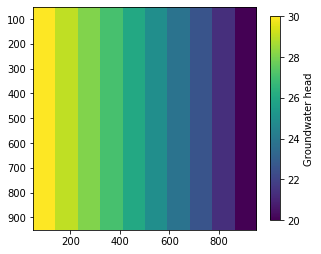

In [14]:
# Image show of the water table
from flopy.utils.postprocessing import get_water_table
fig = plt.figure(figsize=(5, 5))
ax=fig.add_subplot(1,1,1,aspect='equal')
watertable = get_water_table(heads=head, nodata=-999.99)
plt.imshow(watertable,extent=extent)
plt.colorbar(label='Groundwater head',shrink=0.75)
plt.savefig('../Png/'+'tutorial1a.png')

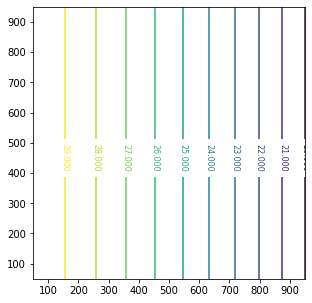

In [15]:
# Head contours
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1,aspect='equal')
contours=plt.contour(head[0, :, :], levels=levels, extent=extent)
plt.clabel(contours, fontsize=8, inline=1)
# colorbar = plt.colorbar(contours,shrink=0.75)
plt.savefig('../Png/'+'tutorial1b.png')

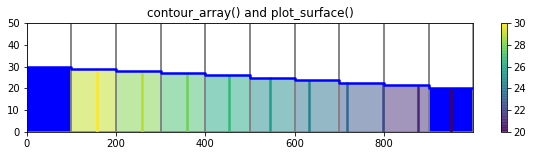

In [16]:
# Crosssectional view of head and constand head boudnary
fig = plt.figure(figsize=(10, 2))
ax = fig.add_subplot(1, 1, 1)
# ax.set_title('plot_array() used to plotting Heads')
xsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': 5})
patches_hd = xsect.plot_array(head, head=head, alpha=0.5)
patches_chd = xsect.plot_ibound(head=head)
linecollection = xsect.plot_grid()
watertable = xsect.plot_surface(head, masked_values=[-999.99], color='blue', lw=2.5)
plt.title('contour_array() and plot_surface()')
contours = xsect.contour_array(head, masked_values=[-999.99], head=head, levels=levels, linewidths=2.5)
colorbar = plt.colorbar(patches_hd)
plt.savefig('../Png/'+'tutorial1c.png')

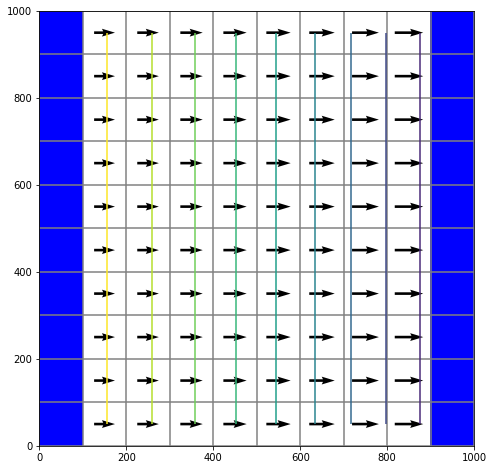

In [17]:
# Plot cell discharge.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

cbb = bf.CellBudgetFile('../Model/'+modelname + '.cbc')
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]

modelmap = flopy.plot.PlotMapView(model=mf, layer=0)
quadmesh = modelmap.plot_ibound()
linecollection = modelmap.plot_grid()
contours = modelmap.contour_array(head, levels=levels)
quiver = modelmap.plot_discharge(frf, fff, head=head)
plt.savefig('../Png/'+'tutorial1d.png')